In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../..')
from loaders import load_sabes
from neurosim.models.subspaces import subspace_identification
from neurosim.models.ssr import StateSpaceRealization as SSR

In [4]:
data_path = '/media/akumar/Secondary/data/sabes/indy_20160627_01.mat'

In [5]:
dat = load_sabes(data_path, spike_threshold=100)

In [6]:
from dca.cov_util import calc_cross_cov_mats_from_data

In [9]:
ccm = calc_cross_cov_mats_from_data(np.squeeze(dat['spike_rates']), T=11)

In [27]:
A, B, C, D, Cbar = subspace_identification(ccm, 3, 1e-2)

A is not a stable matrix


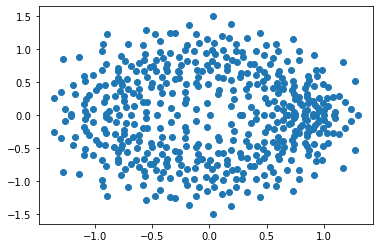

In [23]:
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))

In [32]:
T, Z = scipy.linalg.schur(A)

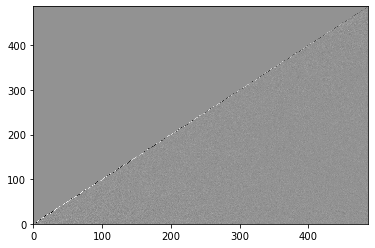

In [37]:
plt.pcolor(T, cmap='Greys')

In [40]:
T[0, :]

array([-1.27975744e+00, -8.08329690e-01, -9.04127800e-03,  8.71155355e-02,
       -1.38910800e-01, -1.05705327e-01, -2.21200585e-02, -2.16154904e-01,
       -4.69518595e-02,  7.54365744e-02,  7.62193991e-02,  5.81206396e-02,
       -3.93767905e-02,  1.37563184e-01,  3.46081886e-02, -3.77193404e-02,
       -1.59330394e-01,  4.23686631e-02,  6.90248549e-02, -1.31292493e-02,
        1.87972322e-02,  5.35701635e-02,  1.56070636e-01,  1.34095635e-01,
       -5.39888845e-02,  6.56789507e-02, -1.89526435e-01,  1.32259787e-01,
        2.28890829e-02, -9.33397020e-02, -1.36483238e-02, -1.34637296e-02,
       -1.02071303e-01, -8.86179858e-02,  1.40725505e-01,  5.57839085e-04,
        1.33811736e-01, -2.42607536e-02,  7.49392812e-02, -4.13458406e-02,
        4.00901692e-02, -3.06370960e-02,  2.81428916e-02,  1.93403604e-01,
        1.40484303e-01, -9.47605253e-02, -9.20549848e-02, -9.75052043e-02,
        1.56000443e-02,  5.97240437e-02, -1.06229967e-01, -1.38637394e-01,
       -1.32378186e-01,  

In [42]:
off_diag = []
for i in range(1, T.shape[0]):
    for j in range(i, T.shape[0]):
        off_diag.append(T[i, j])

(array([1.7000e+01, 4.1000e+01, 6.8000e+01, 1.6700e+02, 5.3500e+02,
        1.6600e+03, 4.4360e+03, 9.8090e+03, 1.7997e+04, 2.4143e+04,
        2.4286e+04, 1.7692e+04, 9.9720e+03, 4.4040e+03, 1.6550e+03,
        5.4900e+02, 2.0500e+02, 8.8000e+01, 1.9000e+01, 2.0000e+01]),
 array([-0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125, -0.1  , -0.075,
        -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,
         0.15 ,  0.175,  0.2  ,  0.225,  0.25 ]),
 <BarContainer object of 20 artists>)

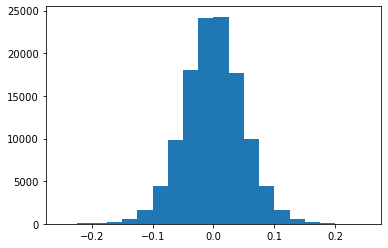

In [47]:
plt.hist(off_diag, bins=20, range=(-0.25, 0.25))

In [30]:
ssr = SSR(A=A, B=B, C=C, D=D)

In [31]:
# Correlation between DCA/PCA loadings

In [83]:
from sklearn.decomposition import PCA
from dca.dca import DynamicalComponentsAnalysis as DCA
from utils import calc_loadings
import torch
from pyuoi.linear_model.var import VAR

In [52]:
pcamodel = PCA(n_components=2)
pcamodel.fit(np.squeeze(dat['spike_rates']))

PCA(n_components=2)

In [55]:
pcamodel.components_.shape

(2, 173)

In [56]:
pca_loadings = calc_loadings(pcamodel.components_.T)

In [58]:
eig, U = np.linalg.eig(ssr.cov)
eigorder = np.argsort(np.abs(eig))[::-1]
U = U[:, eigorder]

In [59]:
model_cov_loadings = calc_loadings(U[:, 0:2])

In [60]:
scipy.stats.pearsonr(pca_loadings, model_cov_loadings)

(0.7068820787300345, 1.6538842097082214e-27)

In [61]:
# Try to calculate DCA loading correlation

In [86]:
varmodel = VAR(estimator='ols')
varmodel.fit(np.squeeze(dat['spike_rates']))

Rows of VAR matrix processed: 173it [00:20,  8.30it/s]


In [87]:
# Run DCA on autocorrelations sequences generated from the network models and evaluate self consistency
X = np.squeeze(dat['spike_rates'])
# X = np.squeeze(dat['spike_rates'])[train_idxs, :]
dcamodel = DCA(T=1, d=2)
dcamodel.estimate_data_statistics(X)
# Run 10 instances of DCA on the empirical data 
coef1 = np.zeros((50, X.shape[1], 2))
for i in tqdm(range(50)): 
    v, _ = dcamodel._fit_projection()
    coef1[i, ...] = v
# Run 10 instances on the model generated data
coef2 = np.zeros((50, X.shape[1], 2))
ssr = SSR(A = A, B=B, C=C)
dcamodel.cross_covs = torch.tensor(ssr.autocorrelation(10))
for i in tqdm(range(50)):
    v, _ = dcamodel._fit_projection()
    coef2[i, ...] = v

coef3 = np.zeros((50, X.shape[1], 2))
ssr = SSR(A = np.squeeze(varmodel.coef_), B=np.eye(varmodel.coef_.shape[-1]), C=np.eye(varmodel.coef_.shape[-1]))
dcamodel.cross_covs = torch.tensor(ssr.autocorrelation(10))
for i in tqdm(range(50)):
    v, _ = dcamodel._fit_projection()
    coef3[i, ...] = v

empirical_loadings = np.array([calc_loadings(coef1[j, ...]) for j in range(coef1.shape[0])])
model_loadings = np.array([calc_loadings(coef2[j, ...]) for j in range(coef2.shape[0])])
model_loadings2 = np.array([calc_loadings(coef3[j, ...]) for j in range(coef3.shape[0])])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.69it/s]


In [90]:
spearman_r2 = np.zeros((50, 50))
for j in range(50):
    for k in range(50):
        spearman_r2[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :],
                                                     model_loadings[k, :])[0]

In [91]:

np.max(spearman_r2)

0.19336117665055094

In [76]:
# How does this compare to VAR models?

In [92]:
spearman_r2 = np.zeros((50, 50))
for j in range(50):
    for k in range(50):
        spearman_r2[j, k] = scipy.stats.spearmanr(empirical_loadings[j, :],
                                                     model_loadings2[k, :])[0]

In [93]:
np.max(spearman_r2)

0.8629635981847764

In [96]:
T, Z = scipy.linalg.schur(np.squeeze(varmodel.coef_))

In [97]:
off_diag = []
for i in range(1, T.shape[0]):
    for j in range(i, T.shape[0]):
        off_diag.append(T[i, j])

(array([1.000e+00, 1.000e+00, 2.000e+00, 1.300e+01, 2.700e+01, 4.800e+01,
        1.060e+02, 3.090e+02, 1.140e+03, 5.710e+03, 5.933e+03, 1.118e+03,
        2.910e+02, 8.900e+01, 4.900e+01, 1.800e+01, 5.000e+00, 5.000e+00,
        3.000e+00, 2.000e+00]),
 array([-0.2 , -0.18, -0.16, -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04,
        -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
         0.16,  0.18,  0.2 ]),
 <BarContainer object of 20 artists>)

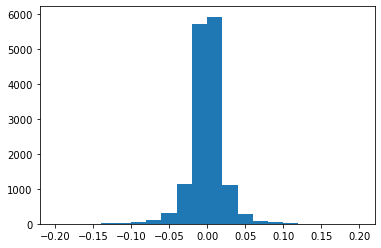

In [101]:
plt.hist(off_diag, range=(-0.2, 0.2), bins=20)

In [ ]:
# Takeaway: Straightforward Subspace Identification is quite poor, however we should seek the *best* 
# parameterization of the second order statistics as we can get

### Try LDS inference with EM

In [6]:
from pylds.models import DefaultLDS

In [7]:
D_obs = 173
D_latent = 100
D_input = 0

In [12]:
model = DefaultLDS(D_obs, D_latent, D_input)
model.add_data(np.squeeze(dat['spike_rates']))

In [13]:
%time     model.EM_step()

/home/akumar/nse/pylds/pylds/states.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [E_xtp1_xtp1T, E_xtp1_xutT, E_xut_xutT, self.T - 1])


CPU times: user 3min 6s, sys: 10.9 s, total: 3min 17s
Wall time: 28.6 s
